In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

### Gap Days

In [106]:
PROVIDED_DATA_DIR = 'data'
CREATED_DATA_DIR = 'data_created'

activity = pd.read_csv(f'{PROVIDED_DATA_DIR}/activity.csv')

In [107]:
# Cast timestamps to datetime
activity['activity_started'] = pd.to_datetime(activity['activity_started'], unit='s')
activity['activity_completed'] = pd.to_datetime(activity['activity_completed'], unit='s')
activity['activity_updated'] = pd.to_datetime(activity['activity_updated'], unit='s')

# Extract date of the day each activity started for later grouping
activity['start_date'] = pd.to_datetime(activity['activity_started'].dt.date, errors='coerce')

# Filter out weird 1970 end times etc.
activity.loc[activity['activity_completed'].dt.year < 2020, 'activity_completed'] = pd.NaT

In [108]:
# Split into finished and unfinished activities

finished_activities = activity[activity['activity_completed'].notna()]
finished_activities = finished_activities.assign(activity_duration=(finished_activities['activity_completed'] -
                                                                   finished_activities['activity_started']).dt.total_seconds()).drop(columns='activity_completed')

# Set a minimum duration
minimum_duration_seconds = 60
finished_activities = finished_activities[finished_activities['activity_duration']>=minimum_duration_seconds]

unfinished_activities = activity[activity['activity_completed'].isna()]

print(f"Finished activities: {finished_activities.shape[0]} ({100*finished_activities.shape[0]/activity.shape[0]})%")
print(f"Uninished activities: {unfinished_activities.shape[0]} ({100*unfinished_activities.shape[0]/activity.shape[0]})%")


Finished activities: 32602 (44.72337681934785)%
Uninished activities: 33778 (46.33661193190392)%


In [109]:
# Split finished activities into those who are finished within the day and those who span multiple days

single_day_activities = finished_activities[finished_activities['activity_duration']<86400]
multi_day_activities = finished_activities[finished_activities['activity_duration']>=86400]

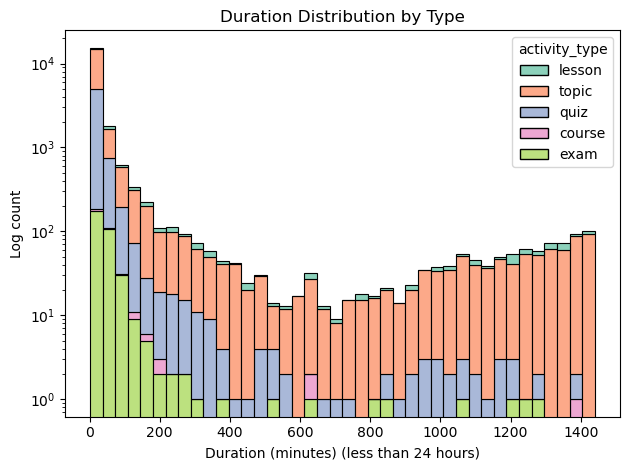

In [110]:
## TODO better text

sns.histplot(
    data=single_day_activities,
    x=single_day_activities['activity_duration']/60,
    hue='activity_type',
    multiple='stack',  
    bins=40,           
    kde=False,         
    palette='Set2'     
)

plt.yscale('log')
plt.xlabel('Duration (minutes) (less than 24 hours)')
plt.ylabel('Log count')
plt.title('Duration Distribution by Type')
plt.tight_layout()
plt.show()

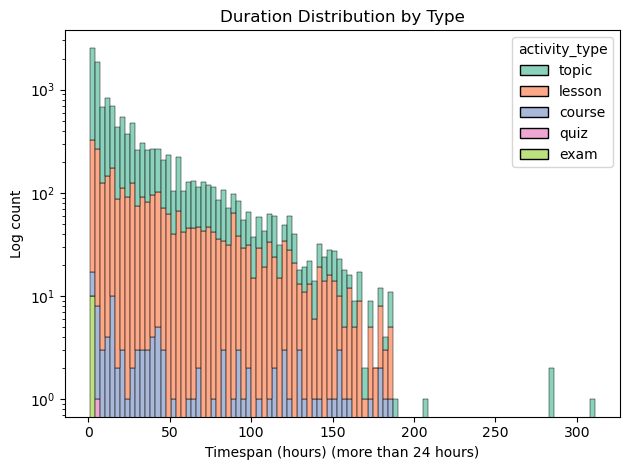

In [111]:
## TODO better text

sns.histplot(
    data=multi_day_activities,
    x=multi_day_activities['activity_duration']/3600/24,
    hue='activity_type',
    multiple='stack',  
    bins=100,           
    kde=False,         
    palette='Set2'     
)

plt.yscale('log')
plt.xlabel('Timespan (hours) (more than 24 hours)')
plt.ylabel('Log count')
plt.title('Duration Distribution by Type')
plt.tight_layout()
plt.show()

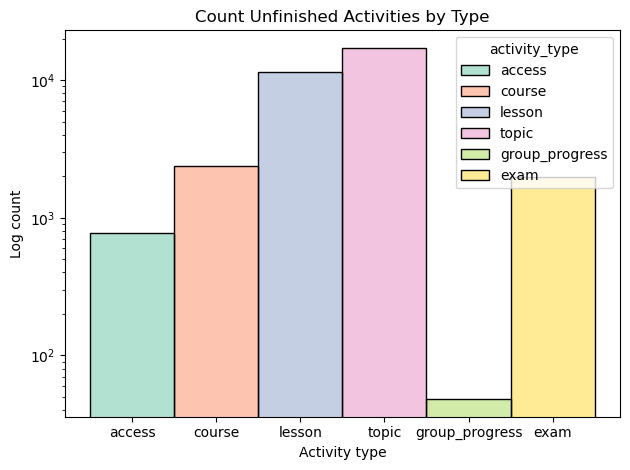

In [112]:
sns.histplot(
    data=unfinished_activities,
    x='activity_type',
    hue='activity_type',      
    kde=False,         
    palette='Set2'     
)

plt.yscale('log')
plt.xlabel('Activity type')
plt.ylabel('Log count')
plt.title('Count Unfinished Activities by Type')
plt.tight_layout()
plt.show()

In [113]:
single_day_activities

,Unnamed: 0,activity_id,user_id,post_id,course_id,activity_type,activity_status,activity_started,activity_updated,start_date,activity_duration
2,77,1113,2533,1699,1696,lesson,1,2023-04-07 16:16:45,2023-04-07 16:33:31,2023-04-07,1006.0
3,78,1114,2533,1769,1696,topic,1,2023-04-07 16:16:57,2023-04-07 16:18:08,2023-04-07,71.0
4,79,1115,2533,1711,1696,topic,1,2023-04-07 16:18:09,2023-04-07 16:31:59,2023-04-07,830.0
7,82,1118,2533,1720,1696,lesson,1,2023-04-07 16:33:31,2023-04-07 16:36:53,2023-04-07,202.0
8,83,1119,2533,1726,1696,topic,1,2023-04-07 16:33:40,2023-04-07 16:36:48,2023-04-07,188.0
...,...,...,...,...,...,...,...,...,...,...,...
72890,625,625,1621,2000625,5009,exam,1,2024-11-19 09:45:12,2024-11-19 11:08:47,2024-11-19,5015.0
72891,626,626,1618,2000626,5009,exam,1,2024-12-25 14:12:53,2024-12-25 14:49:30,2024-12-25,2197.0
72893,628,628,1629,2000628,5009,exam,1,2024-08-26 17:44:36,2024-08-26 18:25:07,2024-08-26,2431.0
72895,630,630,2516,2000630,5009,exam,1,2025-01-04 13:08:50,2025-01-04 13:11:53,2025-01-04,183.0


In [114]:
# Scale duration by activity type and course id: higher is faster (lower duration)

single_day_activities.loc[:, 'duration_scaled'] = (
    single_day_activities.groupby(['activity_type', 'course_id'])['activity_duration']
    .rank(pct=True, method='max')
    .rsub(1)  # same as 1 - rank
)
single_day_activities

/var/folders/tb/xz8bmvcs5mjgtg8nqczpcrcc0000gn/T/ipykernel_86263/60038115.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_day_activities.loc[:, 'duration_scaled'] = (


,Unnamed: 0,activity_id,user_id,post_id,course_id,activity_type,activity_status,activity_started,activity_updated,start_date,activity_duration,duration_scaled
2,77,1113,2533,1699,1696,lesson,1,2023-04-07 16:16:45,2023-04-07 16:33:31,2023-04-07,1006.0,0.421405
3,78,1114,2533,1769,1696,topic,1,2023-04-07 16:16:57,2023-04-07 16:18:08,2023-04-07,71.0,0.939689
4,79,1115,2533,1711,1696,topic,1,2023-04-07 16:18:09,2023-04-07 16:31:59,2023-04-07,830.0,0.201362
7,82,1118,2533,1720,1696,lesson,1,2023-04-07 16:33:31,2023-04-07 16:36:53,2023-04-07,202.0,0.795987
8,83,1119,2533,1726,1696,topic,1,2023-04-07 16:33:40,2023-04-07 16:36:48,2023-04-07,188.0,0.583658
...,...,...,...,...,...,...,...,...,...,...,...,...
72890,625,625,1621,2000625,5009,exam,1,2024-11-19 09:45:12,2024-11-19 11:08:47,2024-11-19,5015.0,0.142276
72891,626,626,1618,2000626,5009,exam,1,2024-12-25 14:12:53,2024-12-25 14:49:30,2024-12-25,2197.0,0.532520
72893,628,628,1629,2000628,5009,exam,1,2024-08-26 17:44:36,2024-08-26 18:25:07,2024-08-26,2431.0,0.443089
72895,630,630,2516,2000630,5009,exam,1,2025-01-04 13:08:50,2025-01-04 13:11:53,2025-01-04,183.0,0.975610


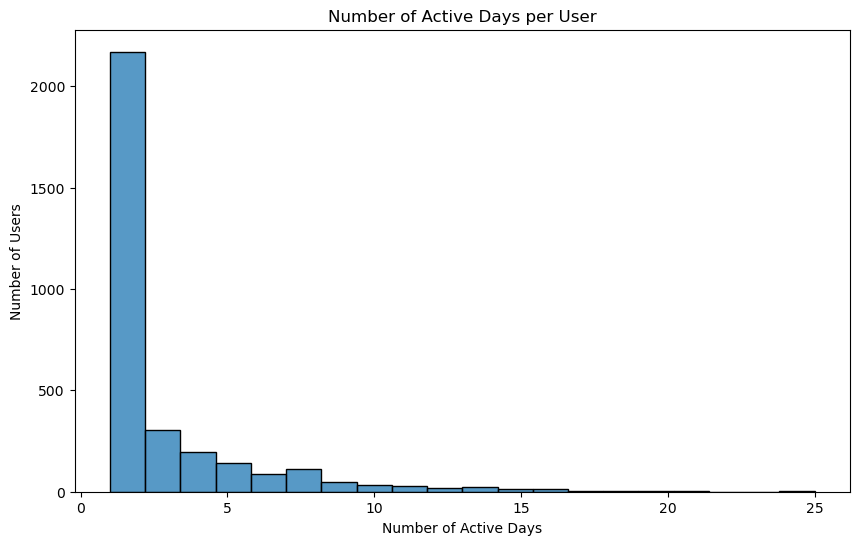

In [115]:
# Define a custom aggregation function
# We mean most relevant columns, but we keep the active days as a set

temp = single_day_activities[['user_id', 'activity_type', 'course_id', 'start_date', 'activity_duration', 'duration_scaled']]
agg_funcs = {
    col: 'mean' for col in temp.columns if col not in ['user_id', 'activity_type', 'course_id', 'start_date']
}
agg_funcs['start_date'] = lambda x: set(x)

# Group , then aggregate
grouped = temp.groupby(['user_id', 'activity_type', 'course_id']).agg(agg_funcs).reset_index()

grouped = grouped.rename(columns={'start_date': 'active_days'})
grouped['active_days_count'] = grouped['active_days'].apply(len)


# Histogram of active days
plt.figure(figsize=(10, 6))
sns.histplot(grouped['active_days_count'], bins=20)
plt.title('Number of Active Days per User')
plt.xlabel('Number of Active Days')
plt.ylabel('Number of Users')
plt.show()



In [116]:
grouped

,user_id,activity_type,course_id,activity_duration,duration_scaled,active_days,active_days_count
0,1,quiz,3301,299.000000,0.335079,{2024-11-02 00:00:00},1
1,1,quiz,3865,583.000000,0.637063,"{2025-02-24 00:00:00, 2025-02-20 00:00:00}",2
2,1,topic,3865,11351.750000,0.403453,"{2025-02-17 00:00:00, 2025-02-13 00:00:00, 202...",3
3,1,topic,5009,2427.333333,0.350934,"{2024-12-07 00:00:00, 2024-11-25 00:00:00, 202...",5
4,4,topic,3301,657.333333,0.520727,"{2024-11-11 00:00:00, 2025-01-24 00:00:00}",2
...,...,...,...,...,...,...,...
3186,4095,lesson,3865,30113.000000,0.118110,{2024-09-04 00:00:00},1
3187,4095,quiz,3301,247.000000,0.481675,{2024-09-03 00:00:00},1
3188,4095,quiz,3865,2366.666667,0.596758,"{2024-10-18 00:00:00, 2024-12-03 00:00:00, 202...",4
3189,4095,topic,3301,18276.750000,0.237818,"{2024-10-22 00:00:00, 2024-09-03 00:00:00}",2


In [117]:
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.metrics import pairwise_distances
import hdbscan

df = grouped.copy()

# ---- CONFIGURE HERE ----
categorical_cols = ['activity_type', 'course_id']                # columns to one-hot encode
normalized_numerical_cols = ['duration_scaled']       # already in [0, 1]
set_col = 'active_days'                                   # column with sets/lists

# ---- STEP 1: Encode categorical columns ----
ohe = OneHotEncoder(sparse_output=False)
cat_encoded = ohe.fit_transform(df[categorical_cols])

# ---- STEP 2: Extract normalized numerical features ----
num_scaled = df[normalized_numerical_cols].values  # already scaled

# ---- STEP 3: Convert set column to binary indicator matrix ----
mlb = MultiLabelBinarizer()
set_binary = mlb.fit_transform(df[set_col])  # assumes list/set format per row

# ---- STEP 4: Compute pairwise distance matrices ----
cat_dists = pairwise_distances(cat_encoded, metric='hamming')
num_dists = pairwise_distances(num_scaled, metric='euclidean')
set_dists = pairwise_distances(set_binary, metric='jaccard')

# ---- STEP 5: Combine distances with weights ----
# Adjust weights as needed; total should ideally sum to 1
w_cat = 0.3
w_num = 0.3
w_set = 0.4

total_dists = w_cat * cat_dists + w_num * num_dists + w_set * set_dists

# ---- STEP 6: Run HDBSCAN ----
clusterer = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=5)
labels = clusterer.fit_predict(total_dists)

# ---- STEP 7: Attach labels to your DataFrame ----
df['cluster'] = labels


/opt/homebrew/Caskroom/miniconda/base/envs/gogymi/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


/opt/homebrew/Caskroom/miniconda/base/envs/gogymi/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


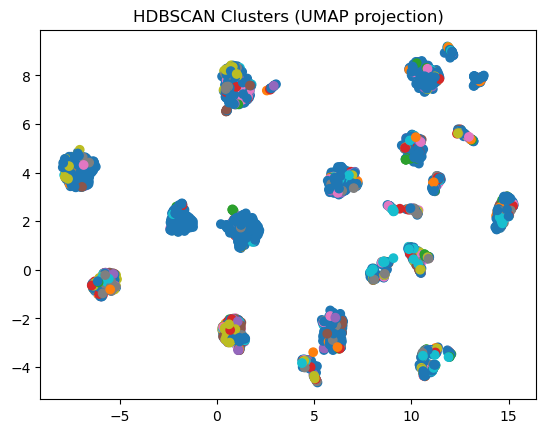

In [118]:
from umap import UMAP
import matplotlib.pyplot as plt

# Concatenate all features
all_features = np.hstack([cat_encoded, num_scaled, set_binary])

embedding = UMAP(n_neighbors=15, min_dist=0.1).fit_transform(all_features)

plt.scatter(embedding[:,0], embedding[:,1], c=labels, cmap='tab10')
plt.title('HDBSCAN Clusters (UMAP projection)')
plt.show()


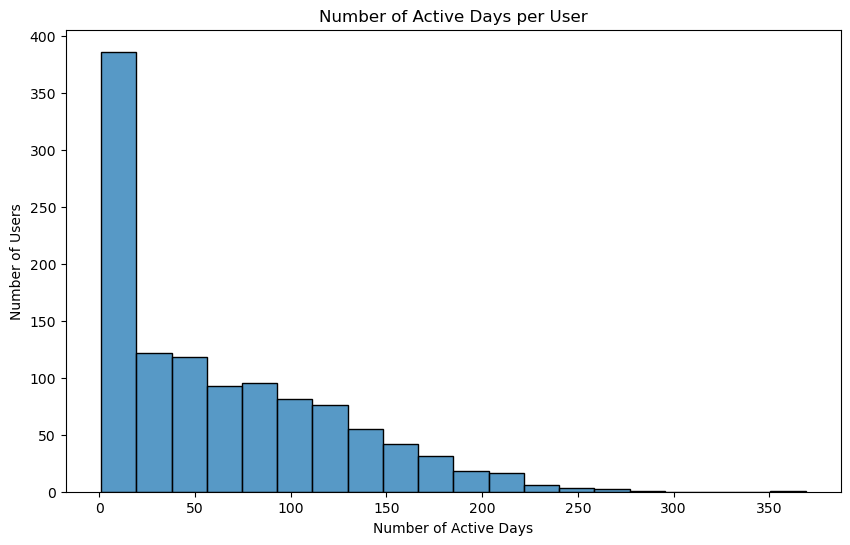

In [119]:
# Histogram of activity durations
plt.figure(figsize=(10, 6))
sns.histplot(activity['user_id'].value_counts(), bins=20)
plt.title('Number of Active Days per User')
plt.xlabel('Number of Active Days')
plt.ylabel('Number of Users')
plt.show()

In [4]:
# Create new column for activity started day
activity['active_day'] = pd.to_datetime(activity['activity_started'].dt.date)

# Drop duplicates in user_id, active_day
activity.drop_duplicates(subset=['user_id', 'active_day'], inplace=True, keep='first')

In [5]:
# Compute gaps between active days for each user
activity.sort_values(['user_id', 'active_day'], inplace=True)
activity['previous_day'] = activity.groupby('user_id')['active_day'].shift(1)
activity['gap_days'] = (activity['active_day'] - activity['previous_day']).dt.days

In [6]:
# Keep only relevnt columns
columns = ['user_id', 'active_day', 'gap_days']
activity = activity[columns]

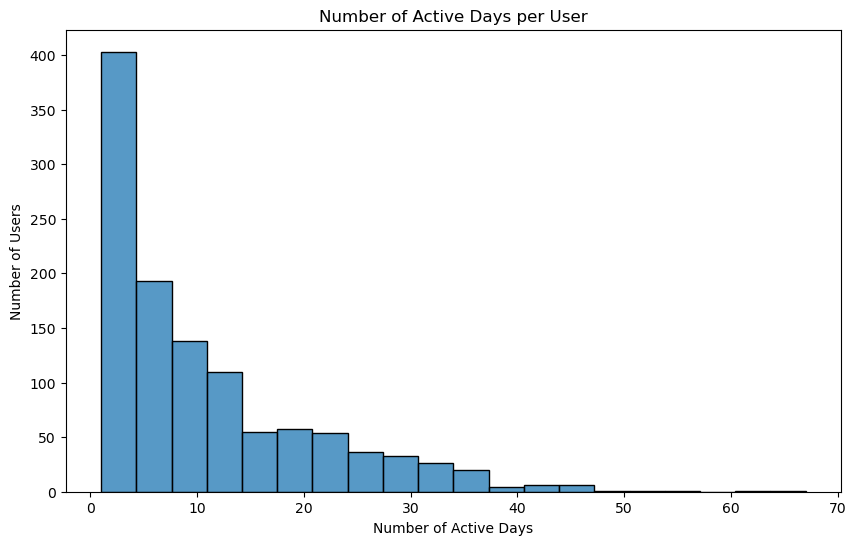

In [7]:
# Histogram of number of active days per user
plt.figure(figsize=(10, 6))
sns.histplot(activity['user_id'].value_counts(), bins=20)
plt.title('Number of Active Days per User')
plt.xlabel('Number of Active Days')
plt.ylabel('Number of Users')
plt.show()

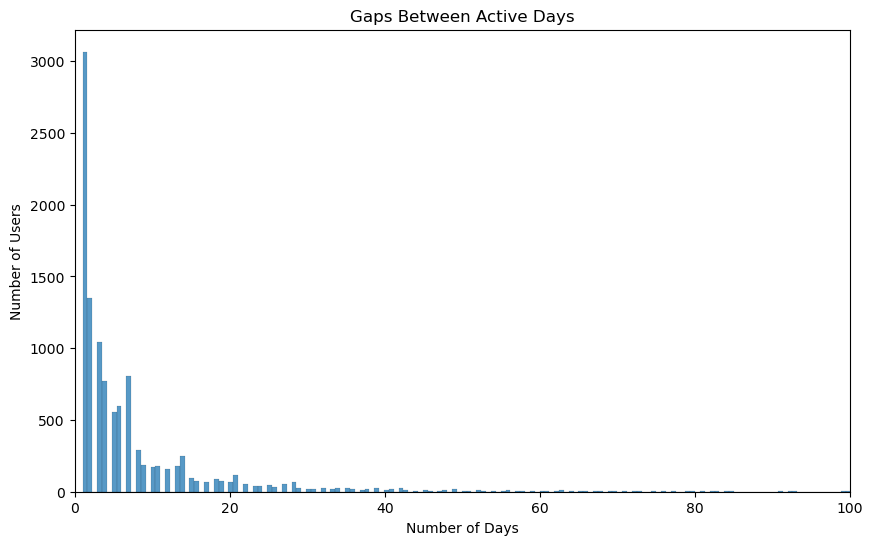

In [8]:
# Histogram of gaps between active days (x from 0 to 100 days)
plt.figure(figsize=(10, 6))
sns.histplot(activity['gap_days'])
plt.title('Gaps Between Active Days')
plt.xlabel('Number of Days')
plt.ylabel('Number of Users')
plt.xlim(0, 100)
plt.show()

In [9]:
display(activity.head())
print(f'Number of rows: {activity.shape[0]}')
print(f'Number of unique users: {activity.user_id.nunique()}')

,user_id,active_day,gap_days
31764,1,2024-10-26,NaN
34732,1,2024-10-30,4.0
35439,1,2024-10-31,1.0
35871,1,2024-11-01,1.0
36115,1,2024-11-02,1.0


Number of rows: 12237
Number of unique users: 1146


In [10]:
# Save the cleaned data
if not os.path.exists(CREATED_DATA_DIR):
    os.makedirs(CREATED_DATA_DIR)

activity.to_csv(f'{CREATED_DATA_DIR}/activity_cleaned.csv', index=False)